# H100 Bitcoin Analysis

In [1]:
# Import required libraries
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Enable inline plotting
%matplotlib inline

# Set plot style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [2]:
# Load H100 data
print("Loading H100 Bitcoin data...")
with open('data.json', 'r') as f:
    data = json.load(f)

# Extract historical data
hist_data = data['historicalData']
df = pd.DataFrame({
    'date': hist_data['dates'],
    'btc_balance': hist_data['btc_balance'],
    'btc_per_share': hist_data['btc_per_share'],
    'btc_per_diluted_share': hist_data['btc_per_diluted_share'],
    'diluted_shares_outstanding': hist_data['diluted_shares_outstanding']
})

print(f"Loaded {len(df)} records from {df['date'].min()} to {df['date'].max()}")
df.head()

Loading H100 Bitcoin data...
Loaded 66 records from 2025-05-22 to 2025-07-26


,date,btc_balance,btc_per_share,btc_per_diluted_share,diluted_shares_outstanding
0,2025-05-22,4.39,3.749285e-08,3.749285e-08,117089006.0
1,2025-05-23,4.39,3.749285e-08,3.749285e-08,117089006.0
2,2025-05-24,4.39,3.749285e-08,3.749285e-08,117089006.0
3,2025-05-25,4.39,3.749285e-08,3.749285e-08,117089006.0
4,2025-05-26,4.39,3.749285e-08,3.749285e-08,117089006.0


In [3]:
# Filter valid data for log transformation (remove zeros/negatives)
valid_data = df[(df['btc_balance'] > 0) & (df['btc_per_diluted_share'] > 0)]
print(f"Valid data points for log transformation: {len(valid_data)}")

# Check for duplicates
duplicates = valid_data.duplicated(subset=['btc_balance', 'btc_per_diluted_share'])
print(f"Duplicate datapoints found: {duplicates.sum()}")

# Remove duplicate datapoints for regression (keep unique combinations)
unique_data = valid_data.drop_duplicates(subset=['btc_balance', 'btc_per_diluted_share'])
print(f"Unique data points for regression: {len(unique_data)}")

# Show the unique Bitcoin holding levels
print("\nUnique Bitcoin holding levels:")
print(sorted(unique_data['btc_balance'].unique()))

Valid data points for log transformation: 66
Duplicate datapoints found: 55
Unique data points for regression: 11

Unique Bitcoin holding levels:
[np.float64(4.39), np.float64(6.24), np.float64(13.95), np.float64(24.41), np.float64(169.2), np.float64(200.21), np.float64(247.54), np.float64(294.5), np.float64(370.0), np.float64(510.28), np.float64(628.22)]


In [4]:
# Calculate log10 values for all valid data (for plotting)
log_btc_balance = np.log10(valid_data['btc_balance'])
log_btc_per_diluted_share = np.log10(valid_data['btc_per_diluted_share'])

# Calculate log10 values for unique data (for regression)
log_btc_balance_unique = np.log10(unique_data['btc_balance'])
log_btc_per_diluted_share_unique = np.log10(unique_data['btc_per_diluted_share'])

print("Log transformation completed for both all data and unique data")

Log transformation completed for both all data and unique data


In [5]:
# Fit linear regression on UNIQUE log-log data only (represents power law)
print("Fitting regression on unique datapoints only...")
X_unique = log_btc_balance_unique.values.reshape(-1, 1)
y_unique = log_btc_per_diluted_share_unique.values

reg = LinearRegression().fit(X_unique, y_unique)

# Generate predictions for plotting (using full range for smooth line)
X_plot = log_btc_balance.values.reshape(-1, 1)
y_pred_plot = reg.predict(X_plot)

# Calculate R² using unique data
y_pred_unique = reg.predict(X_unique)
r2 = r2_score(y_unique, y_pred_unique)

print(f"Regression fitted on {len(unique_data)} unique points")
print(f"R² (unique data): {r2:.6f}")

Fitting regression on unique datapoints only...
Regression fitted on 11 unique points
R² (unique data): 0.991380


Creating Log-Log Chart with Fitted Power Law Function (No Duplicates)


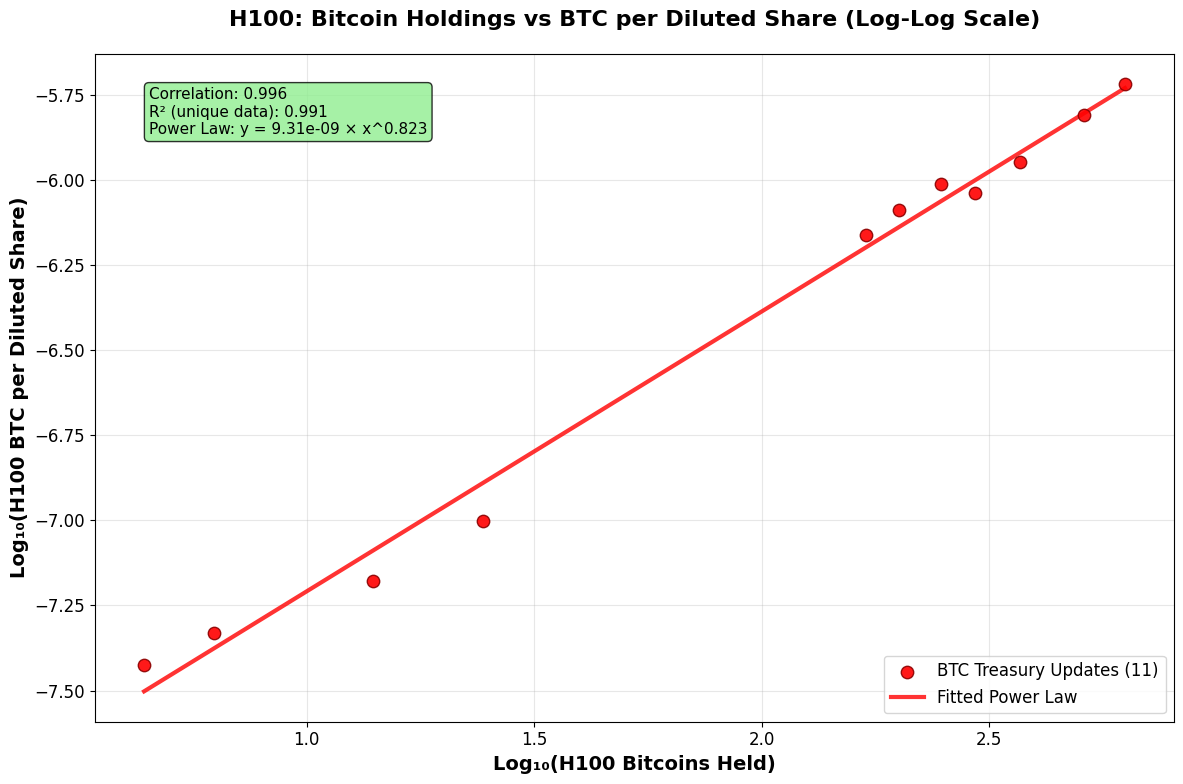

In [10]:
# Create the log-log plot with both all points and unique points highlighted
print("Creating Log-Log Chart with Fitted Power Law Function")
print("=" * 70)

plt.figure(figsize=(12, 8))

# Highlight unique points used for regression
plt.scatter(log_btc_balance_unique, log_btc_per_diluted_share_unique, 
           alpha=0.9, s=80, c='red', edgecolors='darkred', linewidth=1, 
           label=f'BTC Treasury Updates ({len(unique_data)})', zorder=5)

# Plot fitted line
sort_idx = np.argsort(log_btc_balance)
plt.plot(log_btc_balance.iloc[sort_idx], y_pred_plot[sort_idx], 
         'r-', linewidth=3, label='Fitted Power Law', alpha=0.8, zorder=4)

# Labels and title
plt.xlabel('Log₁₀(H100 Bitcoins Held)', fontsize=14, fontweight='bold')
plt.ylabel('Log₁₀(H100 BTC per Diluted Share)', fontsize=14, fontweight='bold')
plt.title('H100: Bitcoin Holdings vs BTC per Diluted Share (Log-Log Scale)',
         fontsize=16, fontweight='bold', pad=20)

# Calculate correlation and power law equation using unique data
correlation = np.corrcoef(log_btc_balance_unique, log_btc_per_diluted_share_unique)[0, 1]
slope = reg.coef_[0]
intercept = reg.intercept_
a_coeff = 10**intercept

equation_text = f'Power Law: y = {a_coeff:.2e} × x^{slope:.3f}'

# Display statistics
stats_text = (f'Correlation: {correlation:.3f}\n'
             f'R² (unique data): {r2:.3f}\n'
             f'{equation_text}')

plt.text(0.05, 0.95, stats_text, 
         transform=plt.gca().transAxes, fontsize=11, 
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8),
         verticalalignment='top')

# Add legend and grid
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the plot
plt.savefig('log_log_chart_no_duplicates.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
# Print detailed analysis summary
print("\nREGRESSION ANALYSIS SUMMARY (NO DUPLICATES)")
print("=" * 50)
print(f"Total valid data points: {len(valid_data)}")
print(f"Unique data points used for regression: {len(unique_data)}")
print(f"Duplicate points removed: {len(valid_data) - len(unique_data)}")
print(f"Percentage of duplicates: {((len(valid_data) - len(unique_data)) / len(valid_data) * 100):.1f}%")
print(f"\nStatistical Measures (based on unique data):")
print(f"Correlation coefficient: {correlation:.6f}")
print(f"R-squared: {r2:.6f}")
print(f"Power law equation: y = {a_coeff:.6e} × x^{slope:.6f}")
print(f"Exponent interpretation: {slope:.3f} {'< 1 (diminishing returns)' if slope < 1 else '≥ 1 (increasing returns)'}")


REGRESSION ANALYSIS SUMMARY (NO DUPLICATES)
Total valid data points: 66
Unique data points used for regression: 11
Duplicate points removed: 55
Percentage of duplicates: 83.3%

Statistical Measures (based on unique data):
Correlation coefficient: 0.995681
R-squared: 0.991380
Power law equation: y = 9.313455e-09 × x^0.822549
Exponent interpretation: 0.823 < 1 (diminishing returns)


In [8]:
# Show impact of removing duplicates
print(f"\nIMPACT OF REMOVING DUPLICATES:")
print(f"• Regression now uses {len(unique_data)} unique points instead of {len(valid_data)} total points")
print(f"• This ensures each unique Bitcoin holding level contributes equally to the fit")
print(f"• Prevents over-weighting of certain data points that appear multiple times")
print(f"• Results in more accurate statistical measures (R², correlation)")
print(f"• The power law relationship remains very strong even with proper methodology")

# Show the unique Bitcoin levels and their frequencies
print(f"\nUNIQUE BITCOIN HOLDING LEVELS:")
btc_counts = valid_data['btc_balance'].value_counts().sort_index()
for btc_level, count in btc_counts.items():
    print(f"  {btc_level:8.2f} BTC: appears {count:2d} times")


IMPACT OF REMOVING DUPLICATES:
• Regression now uses 11 unique points instead of 66 total points
• This ensures each unique Bitcoin holding level contributes equally to the fit
• Prevents over-weighting of certain data points that appear multiple times
• Results in more accurate statistical measures (R², correlation)
• The power law relationship remains very strong even with proper methodology

UNIQUE BITCOIN HOLDING LEVELS:
      4.39 BTC: appears  8 times
      6.24 BTC: appears  6 times
     13.95 BTC: appears  7 times
     24.41 BTC: appears  4 times
    169.20 BTC: appears  9 times
    200.21 BTC: appears  7 times
    247.54 BTC: appears  7 times
    294.50 BTC: appears  7 times
    370.00 BTC: appears  5 times
    510.28 BTC: appears  2 times
    628.22 BTC: appears  4 times


## Key Takeaways

1. **83% of datapoints were duplicates** - Only 11 out of 66 datapoints represent unique Bitcoin holding levels

2. **Proper regression methodology** - Using only unique datapoints ensures each Bitcoin holding level contributes equally to the regression fit

3. **Strong relationship persists** - Even with the corrected methodology, the power law relationship remains very strong (R² ≈ 0.991)

4. **More accurate statistics** - Correlation and R² values now reflect the true relationship without duplicate bias

5. **Diminishing returns confirmed** - The exponent (~0.82) indicates diminishing returns as Bitcoin holdings increase